<p align="center">
<img alt="logo" src="https://upload.wikimedia.org/wikipedia/ar/thumb/1/16/Birzeit_University_logo.svg/320px-Birzeit_University_logo.svg.png"/>
<br>
Faculty of Engineering and Technology<br>
Electrical and Computer Engineering Department<br></p>
<hr>
<hr>
<p align="center">
ENCS5343 Computer Vision<br>
<br>
<b>Course Project</b><br>
<b>Arabic Handwritten Character Recognition (AHCR)</b><br>
<br>
Student Name: Maysam Khatib<br>
Student ID: 1190207<br>
Student Name: Ameer Zedany<br>
Student ID: 1190482
</p>
<hr>

# **Introduction**

## **What is Arabic Handwritten Character Recognition AHCR?**

Handwritten character recognition is one of the major fields in Computer Vision and AI. It aims to convert handwritten characters into readable text by machine. The handwritten character recognition system must be able to analyze and understand the unique patterns, strokes, and shapes of handwritten characters and words using different machine learning techniques such as convolutional neural networks (CNNs) or recurrent neural networks (RNNs).

Arabic Handwritten Character Recognition or as known AHCR, is a specialized field in handwritten character recognition. AHCR specializes in reading and analyzing handwritten Arabic text while taking into consideration factors like Arabic writing's semi-cursive style, its orientation from right to left, and the various forms that each character might take depending on where it falls inside a word. The system has to work its way through these complexities, using cutting-edge methods such as Convolutional Neural Networks (CNNs). Beyond transcribing characters, AHCR is important for applications including document digitization and linguistic research.

## **Convolutional Neural Networks (CNNs)**

### **What are CNNs?**

Neural networks are a subset of machine learning and a core component of deep learning techniques. They are made up of node layers, which include an input layer, one or more hidden layers, and an output layer. Each node connects to another and has a weight and threshold. If the output of any particular node exceeds the defined threshold value, that node is activated and sends data to the next layer of the network.

Convolutional Neural Networks (CNNs) are a type of deep neural network used for computer vision, image analysis, and pattern recognition. CNNs excel at capturing hierarchical information using convolutional layers, making them especially useful for applications like image classification and, in the case of this project, Arabic Handwritten Character Recognition (AHCR).

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*e_3GrFGsOxVBTUFKqDpIAw.png">

### **Layers**
* **Convolutional layers**: They are the backbone of CNNs, applying filters to input data and extracting features using convolution processes. These layers are critical for identifying spatial hierarchies and patterns in input images.

* **Pooling Layers**: They downsample feature maps based on a pooling window size, lowering dimensionality while keeping the most important information. Max pooling gets the highest value from a region and this type is the most used one, average pooling computes the average, and global pooling collapses the whole feature map into a single value.

* **Fully Connected Layers**: Fully connected layers connect all neurons to every neuron in the next layer, allowing for high-level feature interpretation. They are used in general in the final layers of CNN architectures. These layers improve character identification in AHCR by correlating extracted features.

* **Dropout Layers**: Dropout is a regularization technique used to prevent overfitting. This layer randomly eliminates neurons during training, forcing the network to learn more robust features rather than memorizing the training data.


### **Activation Functions**
Activation Functions Introduce nonlinearity into the network to enable it to learn complex patterns. There are several activation functions, but the most frequent ones are: 

* **ReLU (Rectified Linear Unit)**: Simple and efficient, neurons are activated for positive inputs and deactivated for negative inputs.
* **Sigmoid**: An S-shaped curve commonly employed in output layers for probability prediction.
* **Tanh (Hyperbolic Tangent)**: Similar to sigmoid, but with a broader range of outputs.

The picture below shows some activation functions:

<img src="https://miro.medium.com/v2/resize:fit:1100/format:webp/1*ZG90ltyYG46grayKQVDDqw.png" width="750">

### **Loss Function**

The loss function computes the difference between the network's predictions and the actual labels. It is used during the compilation to direct the learning process by updating the weights of each neuron to minimize the difference.
Common loss functions for image classification include:
* **Cross-entropy loss**: It calculates the "distance" between two probability distributions, one of which represents the true label and the network's predicted value. It is ideal for multi-class classification.
* **MSE (Mean squared error)**: It calculates the mean of the squared differences between the true label and the network's predicted values. It is frequently used in regression tasks.


### **Optimizer**
The optimizer is an algorithm that adjusts the weights of the network and biases based on the calculated loss. Its objective is to discover the perfect configuration that decreases the loss function.
Common optimizers include:

* **Adam**: An adaptive optimizer that intelligently navigates the networks by combining momentum and adaptability. It adjusts learning rates according to each parameter, giving priority to essential features and reducing noise while retaining memory of previous training stages. Adam is a popular choice for the model's optimization journey because it accelerates convergence and increases accuracy.
* **Stochastic Gradient Descent (SGD)**: It is robust and simple to use, even with noisy data; but, it must be used carefully to prevent false peaks. A reliable choice for effective landscape exploration in optimization.
* **Root Mean Squareprop (RMSprop)**: It is an adaptive learning rate optimization approach that modifies learning rates for each parameter separately. RMSprop is capable of handling irregular datasets and gradient magnitude variations thanks to its adaptive methodology. RMSprop strikes a balance between the adaptability of advanced optimizers like Adam and the simplicity of SGD by keeping a moving average of squared gradients, which helps to produce stable and effective model optimization.


### **Training and Evaluation**
The process of training a Convolutional Neural Network (CNN) involves providing the network with training datasets with their true labels. The CNN network examines each image by randomly assigning values at first, and then compares those values to the input image's class label and updates the weights and biases based on the optimizer and loss functions then compares the new values with the true labels and so on. Many important factors must be taken into account when training CNN, including the number of epochs, and the size of the batch, which both need fine-tuning. Also, using metrics like accuracy and loss is necessary to evaluate model performance.

#### **Batch Size**

The batch size is the amount of samples handled in a single iteration. It affects how frequently weight updates occur, which in turn affects how quickly the model converges. While larger batch sizes can speed up computation but may lead to a less stable training process, smaller batch sizes allow more frequent updates but could result in computational overhead. Finding a balance between computational efficiency and convergence speed requires fine-tuning the batch size.

#### **Epochs**

An "epoch" is a single iteration through the training dataset. During each epoch, the model iterates over mini-batches. Choosing the right number of epochs is essential since a large number can cause overfitting and an insufficient number can cause underfitting. To make sure the model learns the underlying patterns in the data without memorizing noise, a balance needs to be achieved. The network's weights and biases are modified during the training process throughout several epochs.

#### **Accuracy**

One primary metric used to assess the model's performance is accuracy. It is found by calculating the ratio of accurately predicted samples to the total number of samples. High accuracy reflects a robust model, and lower accuracy indicates that the model is not performing well. Accuracy offers information about the model's overall performance on the training and validation datasets.

#### **Loss**

As mentioned previously, the loss is the result of loss function which is the difference between the true and predicted labels. Monitoring loss across epochs ensures that the model is convergent to an ideal configuration that minimizes errors.

#### **Visualization**

Visualization is used to see the training and validation loss and accuracy across epochs. It offers a representation of the model performance during training and validation.

## **Data Augmentation**

<img src="https://www.researchgate.net/publication/347221279/figure/fig1/AS:1023619987673089@1621061431785/Image-data-augmentation-technique-for-increasing-the-size-of-an-image-to-train-a-deep.png" width="750">

> Data augmentation is a technique of artificially increasing the training set by creating modified copies of a dataset using existing data. It includes making minor changes to the dataset or using deep learning to generate new data points.  

### **Data Augmentation Purpose**

The primary goal of data augmentation is to **deal with issues related to limited training data**. In many machine learning settings, gathering huge and diverse datasets might be difficult or expensive. 

Data augmentation is especially effective at **improving a model's generalization performance**. Training on a larger and more varied dataset improves the model's ability to handle previously unseen examples, resulting in greater performance on real-world data. It provides a realistic solution by artificially increasing the amount of the dataset.

Furthermore, it helps **prevent overfitting**, **increase the model accuracy**, and **reduce the cost of labeling and cleaning the raw dataset**.


### **Data Augmentation Techniques**
* **Rotation**: It involves rotating an image by a specific angle, creating a new viewpoint for the model to learn from.

* **Flip**: It involves mirroring images either vertically or horizontally to make different viewpoints.

* **Cropping**: It involves deleting specific parts of an image and produce new images that focus on specific areas. This helps models to recognize the object even if its partially existed.

* **Zooming and Scaling**: It involves changing the size of an image. This helps models to detect objects of various sizes and scales by zooming in, out, and scaling an image.

* **Shear**: It involves performing a shearing transformation to change the shape of images or data points.

* **Color Manipulation**: It involves many techniques such as changing brightness, contrast, and saturation. It enables models to learn from differences in color and illumination.


## **Some Published CNN**

Published CNNs are Convolutional Neural Network architectures that were introduced through academic research, publications, or considerable competitions. These designs often include unique design ideas, breakthroughs, and developments in computer vision and deep learning. These models are well-documented and have made a substantial contribution to the evolution of neural networks.

### **LeNet**

It is one of the first CNN architectures, developed by Yann LeCun and his colleagues in 1998. It was created for handwritten digit recognition. It includes 5 convolutional layers with non-linear activation functions such as tanh, pooling layers, and fully connected layers. It established the basis for following CNNs by demonstrating their performance in image recognition tasks.

The picture below shows the LeNet architecture.

<img src="https://www.researchgate.net/publication/326443781/figure/fig1/AS:649384198946820@1531836666953/LeNet5-structure-diagram.png">

### **AlexNet**

It was created by Alex Krizhevsky, Ilya Sutskever, and Geoffrey Hinton and won the ImageNet Large Scale Visual Recognition Competition (ILSVRC-2012) with its architecture. It includes 5 convolutional layers with ReLU activation function, pooling layers, fully connected layers, dropout layers for regularization, and data augmentation. It showed the power of the depth in CNNs paving the path for modern large-scale image recognition applications.

The picture below shows AlexNet architecture.

<img src="https://www.researchgate.net/publication/320723863/figure/fig4/AS:555386562412544@1509425883272/AlexNet-like-architecture.png">

### **ResNet**

It was created by Kaiming He et al. in 2015 and won the ImageNet Large Scale Visual Recognition Competition (ILSVRC-2015). It introduced the concept of residual learning to overcome training issues in very deep networks and made it easier to train them by solving the issue of vanishing the gradients. It is available in different depths such as ResNet-50 and ResNet-101. This significant architecture enabled the training of extremely deep networks.

The picture below shows the architecture of ResNet-50.

<img src="https://www.mdpi.com/applsci/applsci-13-07967/article_deploy/html/images/applsci-13-07967-g001-550.jpg">


### **DenseNet**

It was developed by Gao Huang, Zhuang Liu, and Laurens van der Maaten. It got remarkable results at ILSVRC-2017. It includes the dense connections with each layer receiving feature maps from all preceding layers, resulting in efficient feature reuse and a lower parameter count. The densely connected structure has performed well in picture classification tests, beating standard architectures in conditions with little data. DenseNet's architecture enhances its capacity to capture detailed information, making it an excellent choice for complicated computer vision applications.

The picture below shows an illustration of the DenseNet-121 architecture.

<img src="https://www.researchgate.net/publication/361359958/figure/fig1/AS:1167817961418756@1655440907660/GoogleNet-and-DenseNet-architectures.ppm">

### **Which One to Use?**

Choosing a published CNN depends on the dataset and the task itself. The table below shows the consideration for choosing the most suitable published CNN.


| Consideration          | LeNet                               | AlexNet                             | ResNet                              | DenseNet                            |
|------------------------|-------------------------------------|-------------------------------------|-------------------------------------|-------------------------------------|
| **Use Case**           | Simple image recognition tasks      | Complex image recognition tasks    | Very deep networks, complex tasks   | Feature-rich architectures, complex tasks |
| **Dataset Size**       | Small to moderate                   | Large                               | Large                               | Large                               |
| **Computational Resources** | Less intensive               | More intensive                      | More intensive                      | More intensive                      |
| **Task Complexity**    | Moderate                            | High                                | Very high                           | Very high                           |
| **Transfer Learning**  | May benefit from transfer learning | Pre-trained models available       | Pre-trained models available       | Pre-trained models available       |


## **Transfer Learning and Pre-trained Model**

<img src="https://images.prismic.io/encord/13c12d3b-7456-47c6-92d9-92552c6c91c9_image3.png?auto=compress,format" width="850">

Transfer learning, when paired with pre-trained models, is an essential component of deep learning, revolutionizing model training across multiple domains. This powerful approach deals with the difficulties of limited labeled data and computational resources by providing a way to apply knowledge learned from pre-training on large-scale datasets.

Transfer learning is the process of transferring a model that has been trained for one job to a related but distinct one. Transfer learning is based on the concept that pre-training knowledge (representations, filters, and feature hierarchies) might be useful for a new task, particularly in situations where data and computational resources are limited. 

The pre-trained models' lower layers effectively capture general characteristics and patterns, offering an incredible amount of knowledge for taking on new tasks. This supports faster convergence by initializing models with pre-learned weights, which not only speeds up training but also improves efficiency.

There are two important techniques used in transfer learning:
1. Fine-tuning: This entails modifying pre trained layer weights and possibly retraining certain layers to adjust for task-specific nuances.
2. Feature Extraction: This involves extracting pertinent features from lower layers and training additional layers for the particular task. 

When these techniques are combined, they allow taking advantage of the pre-existing information stored in pre-trained models, leading to enhanced performance and faster development for a range of applications.

# **Tasks**

## **Import Libraries**

In [4]:
!pip install gdown # library used to download the dataset from a link

  Obtaining dependency information for gdown from https://files.pythonhosted.org/packages/9e/db/c5dad38733f0995dea4480de38df1b3f6222b77b0dc89aad2402d86e2ff4/gdown-5.0.1-py3-none-any.whl.metadata


In [26]:
# Import needed library in the project
import numpy as np # for numerical operations
import pandas as pd # for data manipulation
import matplotlib.pyplot as plt # for the plots

# Libraries to deal with the dataset
import os # for dealing with files and directories (used to download the dataset)
from zipfile import ZipFile # to unzip the dataset zipped file
import gdown # to download the dataset from the provided link
import random # to generate random numbers to get random images to display
import cv2 # to manipulate the images and resize them

# Tensorflow and Keras
import tensorflow as tf # for building and training nueral networks
from tensorflow import keras # nueral network API used for building neural networks
from keras import layers, models # layers for cnn layers, and models for building the model
from keras.callbacks import EarlyStopping # keras callback to stop the running at a specific condition
from keras.preprocessing.image import ImageDataGenerator # for image augmentation

## **Dataset**

The dataset used in the project is pictures of 32x32 pixels of handwritten Arabic characters. The dataset folder contains the training and testing set. The training set images exist in the "Train Images 13440x32x32" folder and they are 13440 training pictures each 32x32 pixels. Their pixel values are in the "csvTrainImages 13440x1024.csv" CSV file, while the labels for them are in the "csvTrainLabel 13440x1.csv" CSV file. The labels value are from 1 which is the first letter in the Arabic alphabet (أ) to 28 which is the last letter in the Arabic alphabet (ي).

In the same way, the testing set images are stored in the "Test Images 3360x32x32" folder, and the test size is 3360 samples. With corresponding pixel values in the "csvTestImages 3360x1024.csv" CSV file, and labels in the "csvTestLabel 3360x1.csv" CSV file.

The dataset allows for the investigation of handwritten Arabic character recognition tasks by providing both original images and flattened representations, allowing for a variety of machine-learning algorithms.

### **Download Dataset**

In [7]:
# download the dataset from the link
file_id = '1ZQ8fSD6WgkXFBKIxMRBMn0-gTwzFjUvz'
download_link = f'https://drive.google.com/u/0/uc?id={file_id}'
zip_file_name = 'project_dataset.zip'

# check if the dataset folder is existed (to not download it again)
dataset_folder_name = 'dataset'
if not os.path.exists(dataset_folder_name) or not any(os.scandir(dataset_folder_name)):

  # check if the zip file is existed
  if not os.path.exists(zip_file_name):
    with open(zip_file_name, 'wb') as zip_file:
      gdown.download(download_link, zip_file_name, quiet=False)

  # make the dataset folder
  os.makedirs(dataset_folder_name, exist_ok=True)

  # unzip the zipped file
  with ZipFile(zip_file_name, 'r') as zip_ref:
    zip_ref.extractall(dataset_folder_name)

  # Remove the zipped file after extraction
  os.remove(zip_file_name)
else:
    print("Dataset is already existed")

Downloading...
From: https://drive.google.com/u/0/uc?id=1ZQ8fSD6WgkXFBKIxMRBMn0-gTwzFjUvz
To: /kaggle/working/project_dataset.zip
100%|██████████| 25.2M/25.2M [00:01<00:00, 21.3MB/s]


The code above is used in case the dataset does not already exist to download it using the gdown library from the provided Google Drive link, unzip it, and organize it into a specific folder. 


### **Discover Dataset Content**

In [4]:
print("Contents of the dataset folder:")
for item in os.listdir(dataset_folder_name):
    print(item)

Contents of the dataset folder:
csvTrainLabel 13440x1.csv
Train+Test Images Matlab.mat
csvTestImages 3360x1024.csv
csvTrainImages 13440x1024.csv
csvTestLabel 3360x1.csv
Test Images 3360x32x32
Train Images 13440x32x32
test images 3360x32x32
train images 13440x32x32
Arabic Handwritten Characters Dataset CSV
arabic handwritten characters dataset csv


### **Data Loading and Preprocessing**

In [8]:
# load the train lables and put them in one dimensional array
train_labels_path = f'{dataset_folder_name}/csvTrainLabel 13440x1.csv'
train_labels = pd.read_csv(train_labels_path, header=None).to_numpy().reshape(-1)
train_labels = train_labels - 1 # to make it zero-based

# load the test lables and put them in one dimensional array
test_labels_path = f'{dataset_folder_name}/csvTestLabel 3360x1.csv'
test_labels = pd.read_csv(test_labels_path, header=None).to_numpy().reshape(-1)
test_labels = test_labels - 1 # to make it zero-based

# load the train images and put them in 4 dimensional array (images with 32x32 pixels and a single grayscale channel)
train_images_path = f'{dataset_folder_name}/csvTrainImages 13440x1024.csv'
train_images = pd.read_csv(train_images_path, header=None).to_numpy().reshape(-1, 32, 32, 1)
train_images = train_images / 255.0 # normalize

# load the test images in 4 dimensional array (images with 32x32 pixels and a single grayscale channel)
test_images_path = f'{dataset_folder_name}/csvTestImages 3360x1024.csv'
test_images = pd.read_csv(test_images_path, header=None).to_numpy().reshape(-1, 32, 32, 1)
test_images = test_images / 255.0 # normalize

The code above preprocesses the dataset. It initially imports the training and test labels from CSV files, then removes 1 from each label to make for zero-based indexing. Then, the flattened pixel values of training and test images are loaded from CSV files, shaped into four-dimensional arrays (number of samples, 32, 32, 1), and normalized by dividing pixel values by 255.0. The normalization ensures that pixel values fall between 0 and 1 to help in reducing the effect of differences in the scale of input features, which can cause some features to dominate the learning process.

### **Prining Data Information**

In [6]:
# print some dataset information
print('*************************************')
print('Training set:')
print('Number of samples:', train_images.shape[0])
print('Number of features (pixels):', train_images.shape[1] * train_images.shape[2])
print('Image shape:', train_images.shape[1:])
print('Number of classes:', len(np.unique(train_labels)))

print('\n*************************************')
print('Testing set:')
print('Number of samples:', test_images.shape[0])
print('Number of features (pixels):', test_images.shape[1] * test_images.shape[2])
print('Image shape:', test_images.shape[1:])
print('Number of classes:', len(np.unique(test_labels)))


*************************************
Training set:
Number of samples: 13440
Number of features (pixels): 1024
Image shape: (32, 32, 1)
Number of classes: 28

*************************************
Testing set:
Number of samples: 3360
Number of features (pixels): 1024
Image shape: (32, 32, 1)
Number of classes: 28


As previously mentioned, the dataset includes a training set of 13,440 samples and a testing set of 3,360 samples. Each sample in both sets is represented by 1,024 features, which correspond to flattened pixels of 32x32 images with a single grayscale channel. The picture form of each sample is (32, 32, 1). Also, the dataset has 28 unique classes, each one representing a specific letter.

### **Display Random Training Images**

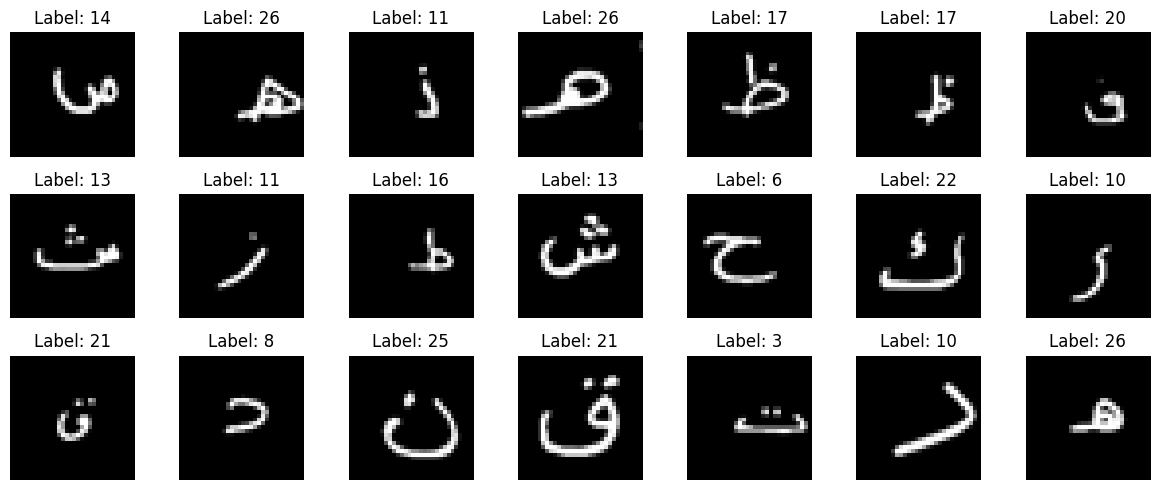

In [7]:
# choose 21 random images from the training dataset
random_indices = np.random.choice(train_images.shape[0], 21, replace=False)

# create a 3x7 grid to plot the random images
fig, axes = plt.subplots(3, 7, figsize=(12, 5))

# plot the images with their labels
for i, ax in enumerate(axes.flat):
    image = train_images[random_indices[i]]
    image = np.rot90(image, axes=(0, 1))
    label = train_labels[random_indices[i]]
    # display the image with a grayscale colormap and lower origin
    ax.imshow(image, cmap='gray', origin='lower')
    # set the label as a title
    ax.set_title(f"Label: {label+1}")
    ax.axis('off')

plt.tight_layout()
plt.show()

The code above selects 21 random samples from the training dataset and displays them in a 3x7 grid using Matplotlib. The np.random.choice function is used to generate random indices for the selected images. Each image with its label that indicates the image class is shown on the plot. The photos are rotated 90 degrees counterclockwise using np.rot90 for better visualization.


## **Plotting Function**


In [9]:
def plotAccuracyLossVsEpochs(history):
    
  # extract the training and testing loss and accuracy  
  training_metrics = [history.history['accuracy'], history.history['loss']]
  testing_metrics =  [history.history['val_accuracy'], history.history['val_loss']]
  titles = ['Accuracy', 'Loss']

  plt.figure(figsize=(12, 5))

  for i in range(0, 2):
    plt.subplot(1, 2, i+1)
    plt.plot(training_metrics[i])
    plt.plot(testing_metrics[i])
    plt.title(f'{titles[i]} vs Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(titles[i])
    plt.legend(['Train', 'Validation'], loc='upper left')

  plt.tight_layout()
  plt.show()

This function visualizes training and validation metrics (accuracy and loss) over epochs when training a machine learning model. The function takes a history object, which typically includes measures generated during the model training process. It generates a figure with two subplots: one for accuracy and another for loss. For each measure, the training and validation curves are plotted on the same graph, with the x-axis representing the epoch. This dual charting enables an easy comparison of the model's performance on the training and validation datasets. The function helps to determine whether the model is learning effectively (by increasing accuracy) and avoids overfitting (by observing the loss on both training and validation sets).
The resulting plots provide insights into the model's performance and can guide adjustments to improve it.

## **Task 1**


Build and train a custom CNN network for AHCR. To build a custom CNN, you need to define the following:

● Architecture:
*   Number of layers: The depth of the network, typically starting with 1 to 2 convolutional layers and gradually increasing for more complex tasks.
*   Types of layers: convolutional layers, pooling layers (max, average, global), fully connected layers, and potentially other specialized layers (e.g., dropout, batch normalization).
*   Activation functions: ReLU (common choice), sigmoid, tanh, or others for specific needs.

● Convolutional Layer Parameters:
* Number of filters: controls the number of feature maps extracted at each layer. More filters can capture more features but increase computational costs.
* Filter size: determines the receptive field of the filters, often starting with 3x3 or 5x5 and increasing in deeper layers.
* Stride: The step size of the filter movement affects the output size and computational complexity.
* Padding: zero-padding input images to preserve spatial dimensions and capture edge features.

● Pooling Layer Parameters:
* Pool size: The size of the pooling window, common choices being 2x2 or 3x3.
* Pool type: max pooling or average pooling, each with different effects on feature preservation.

● Fully Connected Layer Parameters:
* Number of neurons: related to the complexity of the task and the number of classes for classification.

● Training Hyperparameters:
* Learning rate: controls how much the model's weights are updated during training.
* Batch size: the number of samples processed per training step, affecting gradient updates and convergence speed.
* Epochs: The number of times the model trains on the entire dataset.
* Optimizer: algorithm for updating model weights (e.g., Adam, SGD, RMSprop).
* Overfitting Handling: Techniques to prevent overfitting (e.g., dropout, L1/L2
regularization).

### **Build AHCR CNN Model**

In [9]:
def build_ahcr_cnn_model():

  # initialize the model
  model = models.Sequential()

  # create the layers
  layer1_conv = layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 1))
  layer2_pool = layers.MaxPooling2D(pool_size=(2, 2))

  layer3_conv = layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu')
  layer4_pool = layers.MaxPooling2D(pool_size=(2, 2))

  layer5_dropout = layers.Dropout(0.25)

  layer6_flat = layers.Flatten()

  layer7_fc = layers.Dense(units=64, activation='relu')
  layer8_dropout = layers.Dropout(0.5)

  layer9_fc_out = layers.Dense(units=28, activation='softmax')

  # add the layers to the model
  model.add(layer1_conv)
  model.add(layer2_pool)
  model.add(layer3_conv)
  model.add(layer4_pool)
  model.add(layer5_dropout)
  model.add(layer6_flat)
  model.add(layer7_fc)
  model.add(layer8_dropout)
  model.add(layer9_fc_out)

  # combile the model
  model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

  return model

This function creates a CNN model for Arabic handwritten character recognition (AHCR). At first, the model is created by using the model.Sequential() which means a model with linear stacks of layers. Then, the predefined layers are added to the model, these layers are:
1. **Convolutional Layer**: This is the first layer that will take the inputs which are from 32x32 shape. It has 32 filters and a 3x3 kernel size, the used activation function is relu to apply the non-linearity to the model.

2. **Max Pooling Layer**: This layer is used directly after the convolutional layer to downsample the dimensionality and reduce the computational complexity. The used pooling size is 2x2 which means that from each 2x2 region, it will take the maximum value. 

3. **Convolutional Layer**: Another convolutional layer is added but with 64 filters, a 3x3 kernel size, and ReLU activation.

4. **Max Pooling Layer**: Similar to the previous max pooling layer, this layer reduces spatial dimensions with a 2x2 pooling window.

5. **Dropout Layer**: A dropout layer with a dropout rate of 0.25 is included to prevent overfitting by randomly deactivating a fraction of input units during training.

6. **Flatten Layer**: This layer flattens the output from the previous layers, converting it to a one-dimensional vector to prepare for the fully connected layers.

7. **Fully Connected Layer**: A dense layer with 64 neurons and ReLU activation is added.

8. **Dropout Layer**: Another dropout layer with a dropout rate of 0.5 is inserted between the fully connected layers.

9. **Output Layer**: The final layer consists of 28 units (equal to the number of classes), utilizing the softmax activation function which is used for the multi-class classification.

The model then is compiled using **Adam** optimizer, a **sparse categorical cross-entropy** loss function, and **accuracy** as the evaluation criteria. 

In [16]:
ahcr_model = build_ahcr_cnn_model()

ahcr_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 15, 15, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 6, 6, 64)          0         
                                                                 
 flatten_2 (Flatten)         (None, 2304)             

The model is created, and then the information "summary" is shown above. As noticed, after each pooling layer, the size of the dimensions is reduced by half. Also, after the flattening, the shape becomes flattened -> 6x6x64 = 2304

In [17]:
# define the Early Stopping callback to monitor validation loss
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = ahcr_model.fit(
    train_images, # x_train
    train_labels, # y_train
    epochs=200, # max number of training epochs
    batch_size=64, # number of samples for each training iteration
    validation_data=(test_images, test_labels), # validation data to evaluate model performance while training
    callbacks=[early_stopping] # the early stopping callback to stop the training if there is no improvement in val_loss
)

Epoch 1/200


2024-01-30 03:18:49.423013: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_4/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


210/210 [==============================] - 2s 4ms/step - loss: 2.6501 - accuracy: 0.2166 - val_loss: 1.6085 - val_accuracy: 0.5387
Epoch 2/200
210/210 [==============================] - 1s 4ms/step - loss: 1.7538 - accuracy: 0.4397 - val_loss: 1.0326 - val_accuracy: 0.7131
Epoch 3/200
210/210 [==============================] - 1s 4ms/step - loss: 1.3396 - accuracy: 0.5567 - val_loss: 0.7589 - val_accuracy: 0.7827
Epoch 4/200
210/210 [==============================] - 1s 4ms/step - loss: 1.0899 - accuracy: 0.6357 - val_loss: 0.6203 - val_accuracy: 0.8226
Epoch 5/200
210/210 [==============================] - 1s 4ms/step - loss: 0.9594 - accuracy: 0.6771 - val_loss: 0.5356 - val_accuracy: 0.8500
Epoch 6/200
210/210 [==============================] - 1s 4ms/step - loss: 0.8512 - accuracy: 0.7127 - val_loss: 0.4802 - val_accuracy: 0.8586
Epoch 7/200
210/210 [==============================] - 1s 4ms/step - loss: 0.7788 - accuracy: 0.7316 - val_loss: 0.4360 - val_accuracy: 0.8711
Epoch 8/200

The code above trains the model on the training data, and uses the testing set as a validation set. This helps the model to evaluate its performance, enhance the generalization, and prevent overfitting The early stopping is used to prevent overfitting and improve the model's generalization to unseen data. The early stopping callback was created to stop training if the val_loss is not improving for the specific number of consecutive epochs (the number of patience).

`restore_best_weights=True` ensures the model's weights are returned to the values that achieved the best validation results.

The reason for using `val_loss` as a monitor is to prevent overfitting. While accuracy is a significant parameter, particularly for classification tasks, val_loss often comes first during early stops to direct the model toward better generalization.

Number of Epochs: 61

Training Accuracy: 0.929092288017273
Training Loss: 0.1886415183544159

105/105 [==============================] - 0s 3ms/step - loss: 0.1880 - accuracy: 0.9500
Test Accuracy: 0.949999988079071
Test Loss: 0.1880301684141159


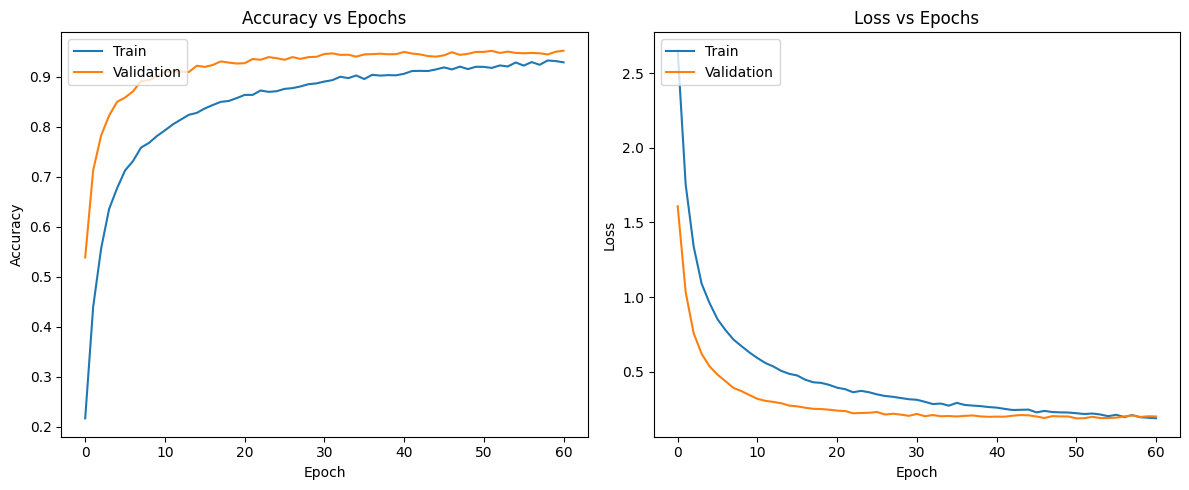

In [18]:
num_epochs = len(history.history['accuracy'])
print(f'Number of Epochs: {num_epochs}\n')

final_train_accuracy = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]
print(f'Training Accuracy: {final_train_accuracy}')
print(f'Training Loss: {final_train_loss}\n')

# evaluating the test set on the model
test_loss, test_accuracy = ahcr_model.evaluate(test_images, test_labels)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

# plot the results
plotAccuracyLossVsEpochs(history=history)

The code above is used to evaluate the model and print the metrics for both the training and testing set. It also plots the loss and accuracy vs epochs.

The evaluation metrics used include training accuracy, training loss, test accuracy, and test loss. Accuracy is a measure of correct predictions over the total number of predictions, while loss represents the model's error.

From the results above, the number of epochs used to train the model to achieve high accuracy without reaching overfitting: **61**. 

The training accuracy is **92.91%** which means that the model learns well from the training dataset.

The training loss is **0.1886** which is the model error, it is low which is good and means that the predictions can match the actual labels well.

The test accuracy is **94.99%** and it measures the model performance to the unseen data, the value is high which means good performance.

The test loss is **0.1880**, which indicates a low model error.

When the number of epochs increased, the accuracy for training and validation increased, with a higher accuracy for the validation set and convergence of both of them over time. This means that model becomes more accurate while the epochs is increasing (to some extent because the extremely high number of epochs leads to overfitting).

When the number of epochs increased, the loss for training and validation decreased, with a lower loss for the validation set and convergence of both of them over time. This means that the model is minimizing the error over the time.

So based on the results and plots, **the model learned the training data effectively and can generalize well to unseen data**. The test accuracy is higher than the training accuracy, and the test loss is lower than the training loss which means that the model is not overfitting to the training dataset.

## **Task 2**


Retrain the network selected from Task 1 after doing data augmentation.
Data augmentation is a powerful technique for enhancing the diversity and the size of your training data without the need for additional data collection. By applying various transformations to existing data points, you can train models that generalize better to unseen examples and improve their overall performance.

Data augmentation encompasses a wide range of techniques, only a subset of which are suitable for training the AHCR system. In this task, you must select at least three data augmentation techniques that are appropriate and for the model you trained, you need to plot the following:

1. Training loss vs. epoch.
2. Validation loss vs. epoch.
3. Training accuracy vs. epoch.
4. Testing accuracy vs. epoch.

Compare the results you obtained with the results of Task 1.

In [13]:
datagen = ImageDataGenerator(
    rotation_range=15,  # random rotations between -15 and 15 degrees
    width_shift_range=0.15,  # horizontal shifts by 15% of the image width
    height_shift_range=0.15,  # vertical shifts by 15% of the image height
    shear_range=0.2,  # random shearing transformations by 20%
    zoom_range=0.2  # random zooming by 20%
) #95.3

datagen.fit(train_images) # fit the training set to the datagen
'''datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2
) #88.8

datagen = ImageDataGenerator(
    rotation_range=5,
    width_shift_range=0.03,
    height_shift_range=0.03,
    horizontal_flip=True
) #87.9'''

'datagen = ImageDataGenerator(\n    rotation_range=20,\n    width_shift_range=0.2,\n    height_shift_range=0.2,\n    shear_range=0.2,\n    zoom_range=0.2\n) #88.8\n\ndatagen = ImageDataGenerator(\n    rotation_range=5,\n    width_shift_range=0.03,\n    height_shift_range=0.03,\n    horizontal_flip=True\n) #87.9'

The code above is responsible for data augmentation to apply during the training. Many configurations have been tried, then the one that results in the highest accuracy was chosen.

The best configuration:

1. `rotation_range=15`: each input image might be randomly rotated by an angle between -15 and +15 degrees during data augmentation. The training dataset is intentionally made more diverse by randomly applying the rotation to several images.

2. `width_shift_range=0.15`: for each input image, a maximum fraction of 0.15 times the image's total width may be applied at random to move it vertically.

3. `height_shift_range=0.15`: for each input image, a maximum fraction of 0.15 times the image's total width may be applied at random to move it horizontally.

4. `shear_range=0.2`: A maximum of 0.2 percent random shearing may be applied to each input image. Deformation is introduced by the shear transformation, which moves the pixels along one of the axes. 

5. `zoom_range=0.2`: A random zooming with a maximum of 0.2 percent will be applied for each image.

The training data were fit in `datagen` which is a necessary step to prepare the generator for the data augmentation during the training.  It ensures that the statistics used for data augmentation are calculated from the training set, allowing the generator to perform consistent and relevant modifications on input data.

By introducing the model to adjustments in the input data, this strategy helps it become more flexible and capable of resolving different scenarios. The parameters selected are determined by the intended level of augmentation and specific characteristics of the dataset.

In [14]:
ahcr_model_aug = build_ahcr_cnn_model()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history_aug = ahcr_model_aug.fit(datagen.flow(train_images, train_labels, batch_size=64), epochs=200, validation_data=(test_images, test_labels), callbacks=[early_stopping])

Epoch 1/200


2024-01-30 02:32:15.597881: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


210/210 [==============================] - 7s 25ms/step - loss: 3.0909 - accuracy: 0.1051 - val_loss: 2.0690 - val_accuracy: 0.4140
Epoch 2/200
210/210 [==============================] - 5s 24ms/step - loss: 2.4358 - accuracy: 0.2470 - val_loss: 1.3618 - val_accuracy: 0.5988
Epoch 3/200
210/210 [==============================] - 5s 23ms/step - loss: 2.0482 - accuracy: 0.3365 - val_loss: 1.0459 - val_accuracy: 0.6795
Epoch 4/200
210/210 [==============================] - 5s 23ms/step - loss: 1.8434 - accuracy: 0.3948 - val_loss: 0.8962 - val_accuracy: 0.7265
Epoch 5/200
210/210 [==============================] - 5s 24ms/step - loss: 1.6698 - accuracy: 0.4406 - val_loss: 0.8171 - val_accuracy: 0.7381
Epoch 6/200
210/210 [==============================] - 5s 25ms/step - loss: 1.5607 - accuracy: 0.4828 - val_loss: 0.6745 - val_accuracy: 0.7795
Epoch 7/200
210/210 [==============================] - 5s 24ms/step - loss: 1.4557 - accuracy: 0.5136 - val_loss: 0.6181 - val_accuracy: 0.8122
Epoc

As task 1, a new model is created and trained using the data augmentation shown in the previous step. The fit method is used to train the generator produced from datagen.flow (train_images, train_labels, batch_size=64). During training, the generator does random data augmentation, which improves the model's ability to generalize to unseen data. The training process is done for a maximum of 200 epochs, and the model's performance is evaluated on the test set.

Number of Epochs: 98

Training Accuracy: 0.840624988079071
Training Loss: 0.49054524302482605

105/105 [==============================] - 0s 2ms/step - loss: 0.1477 - accuracy: 0.9533
Test Accuracy: 0.9532738327980042
Test Loss: 0.1477229744195938


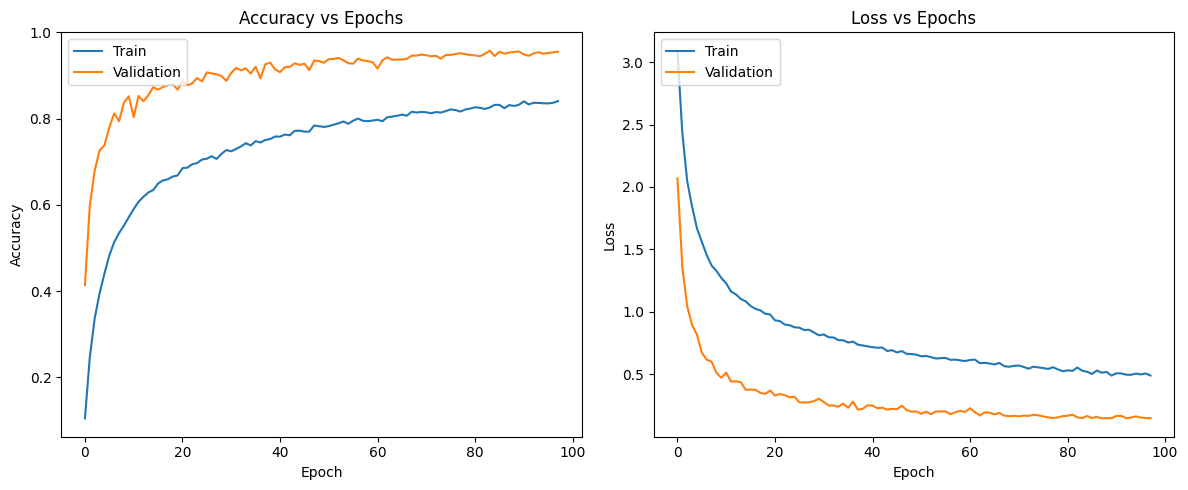

In [15]:
num_epochs = len(history_aug.history['accuracy'])
print(f'Number of Epochs: {num_epochs}\n')

final_train_accuracy = history_aug.history['accuracy'][-1]
final_train_loss = history_aug.history['loss'][-1]
print(f'Training Accuracy: {final_train_accuracy}')
print(f'Training Loss: {final_train_loss}\n')

# evaluating the test set on the model
test_loss, test_accuracy = ahcr_model_aug.evaluate(test_images, test_labels)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

# plot the results
plotAccuracyLossVsEpochs(history=history_aug)

The needed number of epochs is **98 epochs**.

The training accuracy: **84.06%**

The training loss: **0.4905**

The test accuracy: **95.33%**

The test loss: **0.1477**

| Metric                         | Task 1 (Without Data Augmentation) | Task 2 (With Data Augmentation) |
|--------------------------------|--------------------------------------|-----------------------------------|
| Number of Epochs               | 61                                   | 98                                |
| Training Accuracy              | 92.91%                               | 84.06%                            |
| Training Loss                  | 0.1886                               | 0.4905                            |
| Test Accuracy                  | 95.00%                               | 95.33%                            |
| Test Loss                      | 0.1880                               | 0.1477                            |
| Training Time (per epoch)      | 1s 3ms/step                          | 5s 25ms/step                       |


## **Comparison**


#### **Number of Epochs:** 
The model in task 1 required fewer epochs to achieve an acceptable result, whereas task 2 required more epochs. This could be due to the regularization effect of data augmentation in task 2, which may have slowed the learning process and required additional epochs for convergence.

#### **Training Accuracy and Loss:** 
The model without data augmentation achieved better accuracy and lower loss compared to the model with the data augmentation, This is because of the increased complexity in the model in task 2 which made the model requires more careful tuning. The data augmentation makes it more difficult for the model to fit the augmented data accurately.

#### **Test Accuracy and Loss:** 
The model in task 2 performed slightly better on the test set, resulting in higher test accuracy and lower test loss. It means that the data augmentation used in task 2 improved the model's generalization performance on unseen data.

#### **Training Time:** 
The model in task 2 took more time per epoch (5s 23ms/step) than the model in task 1 (1s 4ms/step). The higher time per epoch in task 2 is most likely due to the increased computational cost associated with performing data augmentation on-the-fly during training.

#### **The Plots:** 
As explained in task 1, the accuracies are increasing and the losses are decreasing over the time. But we can see that there is a gap (almost 10%) between the training results and the test results. This means that the test set is easier to predict for the model than the training set because of the more complexity of the training set due to the data augmentation, while the test set has simpler samples.

## **Task 3**

Select a CNN network from a list of well-known and published CNN architectures, such as LeNet,
AlexNet, ResNet, and so on. You must make a tradeoff between accuracy and network complexity with
respect to the problem and the dataset provided. Train it using the data augmentation techniques you
used in Task 2.

### What architecture was chosen?

We chose LeNet architecture for several reasons:

1. LeNet was built specifically for OCR and character recognition jobs.
2. It is simple, efficient, and suitable for limited computational resources, as it is more resistant to overfitting.
3. The task is simple and does not require complex architecture.
4. The dataset itself is moderate and not very large.

So, we chose the leNet architecture after the consideration of the task's requirements, dataset characteristics, and a preference for a proven architecture that aligns well with the problem at hand.

In [10]:
def create_lenet_model():
    # create the model
    model = models.Sequential()
    # layer 1: convolutional layer
    model.add(layers.Conv2D(filters=6, kernel_size=(5, 5), strides=(1, 1), activation='relu', input_shape=(32,32,1)))
    # layer 2: max pooling
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # layer 3: convolutional layer
    model.add(layers.Conv2D(filters=16, kernel_size=(5, 5), strides=(1, 1), activation='relu'))
    # layer 4: max pooling layer
    model.add(layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    # layer 5: flatten layer
    model.add(layers.Flatten())
    # layer 6: fully connected layer
    model.add(layers.Dense(units=120, activation='relu'))
    # layer 7: fully connected layer
    model.add(layers.Dense(units=84, activation='relu'))
    # layer 8: fully connected output layer
    model.add(layers.Dense(units=28, activation='softmax'))
    return model

This function defines a LeNet-inspired architecture. The model consists of the following layers:

1. **Convolutional Layer (Layer 1)**:
   - The first layer is a convolutional layer with 6 filters, a 5x5 kernel, and ReLU activation.
   - The input shape is set to (32, 32, 1), representing our image shape 32x32 grayscale.
   

2. **Max Pooling Layer (Layer 2)**:
   - A max pooling layer with a pool size of 2x2 and 2x2 strides is applied to downsample the spatial dimensions.
   

3. **Convolutional Layer (Layer 3)**:
   - Another convolutional layer is added with 16 filters, a 5x5 kernel, and ReLU activation.
   

4. **Max Pooling Layer (Layer 4)**:
   - Similar to Layer 2, a max pooling layer is applied to further downsample the feature maps.
   

5. **Flatten Layer (Layer 5)**:
   - The output from the convolutional and pooling layers is flattened to prepare for the fully connected layers.
   

6. **Fully Connected Layer (Layer 6)**:
   - A dense layer with 120 neurons and ReLU activation is added.
   

7. **Fully Connected Layer (Layer 7)**:
   - Another dense layer with 84 neurons and ReLU activation is added.
   

8. **Output Layer (Layer 8)**:
   - The final layer is a fully connected output layer with 28 units, corresponding to the number of classes (characters).
   - The activation function used is softmax for multi-class classification.


In [13]:
# create the model and combile it
model = create_lenet_model()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,  # random rotations between -15 and 15 degrees
    width_shift_range=0.15,  # horizontal shifts by 15% of the image width
    height_shift_range=0.15,  # vertical shifts by 15% of the image height
    shear_range=0.2,  # random shearing transformations by 20%
    zoom_range=0.2  # random zooming by 20%
)

datagen.fit(train_images) # fit the training set to the datagen

# train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    datagen.flow(train_images, train_labels, batch_size=64), 
    epochs=200, 
    validation_data=(test_images, test_labels), 
    callbacks=[early_stopping]
    )

Epoch 1/200
210/210 [==============================] - 9s 26ms/step - loss: 2.6336 - accuracy: 0.2057 - val_loss: 1.5553 - val_accuracy: 0.4625
Epoch 2/200
210/210 [==============================] - 5s 25ms/step - loss: 1.7413 - accuracy: 0.4161 - val_loss: 1.1496 - val_accuracy: 0.5869
Epoch 3/200
210/210 [==============================] - 5s 26ms/step - loss: 1.4348 - accuracy: 0.4991 - val_loss: 0.9988 - val_accuracy: 0.6247
Epoch 4/200
210/210 [==============================] - 5s 26ms/step - loss: 1.2557 - accuracy: 0.5636 - val_loss: 0.7585 - val_accuracy: 0.7208
Epoch 5/200
210/210 [==============================] - 5s 26ms/step - loss: 1.1227 - accuracy: 0.6092 - val_loss: 0.7138 - val_accuracy: 0.7414
Epoch 6/200
210/210 [==============================] - 5s 26ms/step - loss: 1.0263 - accuracy: 0.6412 - val_loss: 0.6224 - val_accuracy: 0.7729
Epoch 7/200
210/210 [==============================] - 6s 26ms/step - loss: 0.9800 - accuracy: 0.6603 - val_loss: 0.6349 - val_accuracy:

Number of Epochs: 68

Training Accuracy: 0.8883184790611267
Training Loss: 0.32723695039749146

105/105 [==============================] - 0s 2ms/step - loss: 0.1880 - accuracy: 0.9408
Test Accuracy: 0.9407737851142883
Test Loss: 0.18797633051872253


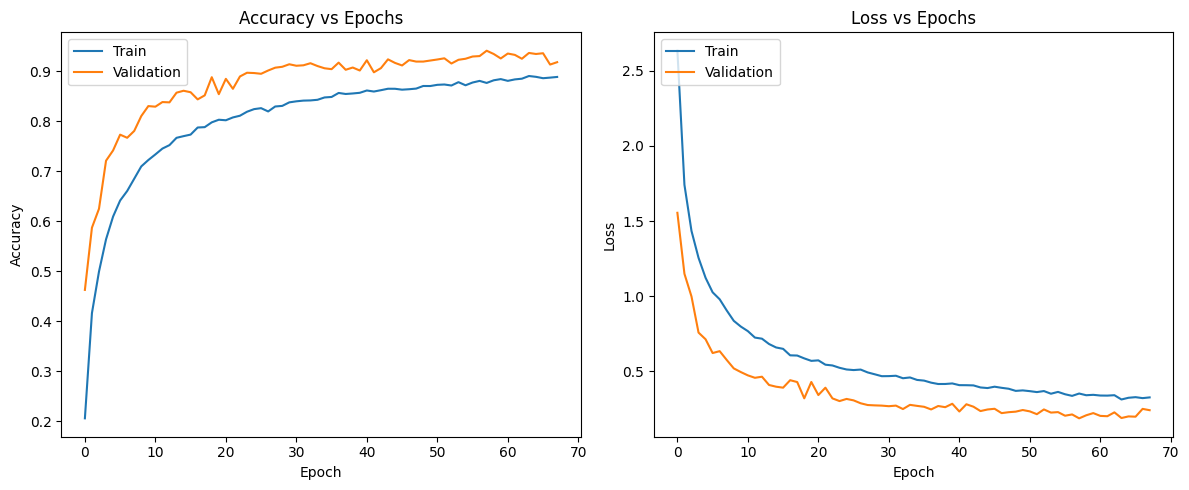

In [14]:
# show the results
num_epochs = len(history.history['accuracy'])
print(f'Number of Epochs: {num_epochs}\n')

final_train_accuracy = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]
print(f'Training Accuracy: {final_train_accuracy}')
print(f'Training Loss: {final_train_loss}\n')

# evaluating the test set on the model
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

# plot the results
plotAccuracyLossVsEpochs(history=history)

The needed number of epochs is **68 epochs**.

The training accuracy: **88.8%**

The training loss: **0.3272**

The test accuracy: **94.08%**

The test loss: **0.1879**

| Metric                         | Task 1 (Without Data Augmentation) | Task 2 (With Data Augmentation) | Task 3 (LeNet with Augmentation) |
|--------------------------------|--------------------------------------|-----------------------------------|----------------------------------|
| Number of Epochs               | 61                                   | 98                                | 68                               |
| Training Accuracy              | 92.91%                               | 84.06%                            | 88.83%                           |
| Training Loss                  | 0.1886                               | 0.4905                            | 0.3272                           |
| Test Accuracy                  | 95.00%                               | 95.33%                            | 94.08%                           |
| Test Loss                      | 0.1880                               | 0.1477                            | 0.1880                           |
| Training Time (per epoch)      | 1s 3ms/step                          | 5s 25ms/step                      | 5s 25ms/step                     |


## **Comparison**

### **Number of Epochs:**
Task 1 required 61 epochs, task 2 needed 98 epochs, and task 3 utilized 68 epochs to reach a satisfactory level of training. Task 1 had the lowest number of epochs because of the absence of data augmentation, suggesting faster convergence, while task 2 required the highest number of epochs because of the regularization effect of data augmentation. While LeNet model needed slightly more epochs than task 1, but less than task two (Although the both models used data augmentation)

### **Training Accuracy and Loss:**
Task 1 achieved the highest training accuracy and the lowest training loss. Task 2, with data augmentation, showed a decrease in training accuracy and an increase in training loss. Task 3, LeNet with data augmentation, achieved an intermediate training accuracy and training loss.

LeNet outperformed the model in task 2 although they are both have the data augmentation, which means that the LeNet ability to learn was better than the model in task 2.

### **Test Accuracy and Loss:**
All of the models resulted a very good test accuracy and low test loss. Task 2 resulted in the highest test accuracy and lowest test loss. Task 1 also performed well on the test set. Task 3 also showed good performance and generalization.

### **Training Time per Epoch:**
Task 1 had the shortest training time per epoch, while task 2 took more time. Task 3, LeNet with data augmentation, had a similar training time per epoch to task 2, emphasizing the computational cost of data augmentation.

### **The Plots:**
All tasks showed increasing accuracies and decreasing losses over time in their plots. The gap between training and test results in task 3 is decreased than what it was in task 2. That means that the LeNet model with data augmentation achieved a more balanced performance across the training and test sets.


## **Task 4**

Use a pre-trained CNN network on similar tasks and choose the appropriate transfer learning
method to fine tune the pretrained network on the given dataset.

We got the model from this Link : https://github.com/aakashjhawar/handwritten-digit-recognition/blob/master/tf-cnn-model.h5

the model dataset are the digits from 0-9 and there are many models were tested but gives low Accuracy.

#### **Load the Pre-trained Model**

In [48]:
model = models.load_model('/kaggle/input/tf-cnn-model-h5/tf-cnn-model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 32)        18464     
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 16)        4624      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 16)          0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 6, 6, 64)          9

This pre-trained model is a sequential convolutional neural network (CNN) for digits recognition. It consists of three convolutional layers (conv2d) with 64, 32, and 16 filters, respectively, followed by max pooling layers to downsample the spatial dimensions. The model also has flatten layer and two dense (fully connected) layers with 128 and 10 units, respectively. The output layer has 10 units with a softmax activation function, indicating the number of digits [0-9].

#### **Adaptation of the Pre-trained model**

In [50]:
# Remove the last layer and add a new one
model = models.Model(inputs=model.inputs, outputs=model.layers[-2].output) 
new_output = layers.Dense(28, activation='softmax', name='new_dense_layer')(model.output)

new_model = models.Model(inputs=model.input, outputs=new_output)
new_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

The last layer of the pretrained model is removed, and a new output layer is added. The new output layer consists of a Dense layer with 28 units which is the number of our output classes. Then the model was combiled.


#### **Resizing the inputs**

In [51]:
train_images_resized = np.array([cv2.resize(img, (28, 28)) for img in train_images])[..., np.newaxis]
test_images_resized = np.array([cv2.resize(img, (28, 28)) for img in test_images])[..., np.newaxis]

The resizing is done to match the input size expected by the pre-trained model. By adding [..., np.newaxis], we're effectively converting each 2D image (28x28) into a 3D image (28x28x1). The 1 represents a single color channel

#### **Data Augmentation**

In [52]:
datagen_pre = ImageDataGenerator(
    rotation_range=15,  
    width_shift_range=0.15,  
    height_shift_range=0.15,  
    shear_range=0.2,  
    zoom_range=0.2  
)
datagen_pre.fit(train_images_resized)

#### **Train the model on our data**

In [55]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = new_model.fit(
    datagen_pre.flow(train_images_resized, train_labels, batch_size=64),
    epochs=200, 
    validation_data=(test_images_resized, test_labels), 
    callbacks=[early_stopping]
    )

Epoch 1/200
210/210 [==============================] - 5s 25ms/step - loss: 0.7647 - accuracy: 0.7443 - val_loss: 0.4109 - val_accuracy: 0.8595
Epoch 2/200
210/210 [==============================] - 5s 24ms/step - loss: 0.6682 - accuracy: 0.7789 - val_loss: 0.3624 - val_accuracy: 0.8717
Epoch 3/200
210/210 [==============================] - 5s 24ms/step - loss: 0.6060 - accuracy: 0.7977 - val_loss: 0.3484 - val_accuracy: 0.8750
Epoch 4/200
210/210 [==============================] - 5s 24ms/step - loss: 0.5373 - accuracy: 0.8201 - val_loss: 0.3136 - val_accuracy: 0.8943
Epoch 5/200
210/210 [==============================] - 5s 24ms/step - loss: 0.4911 - accuracy: 0.8374 - val_loss: 0.2837 - val_accuracy: 0.9137
Epoch 6/200
210/210 [==============================] - 5s 24ms/step - loss: 0.4591 - accuracy: 0.8481 - val_loss: 0.2781 - val_accuracy: 0.9104
Epoch 7/200
210/210 [==============================] - 5s 25ms/step - loss: 0.4272 - accuracy: 0.8563 - val_loss: 0.2769 - val_accuracy:

#### **Display the results**

Number of Epochs: 62

Training Accuracy: 0.9583333134651184
Training Loss: 0.12941202521324158

105/105 [==============================] - 0s 2ms/step - loss: 0.1004 - accuracy: 0.9717
Test Accuracy: 0.9717261791229248
Test Loss: 0.10042369365692139


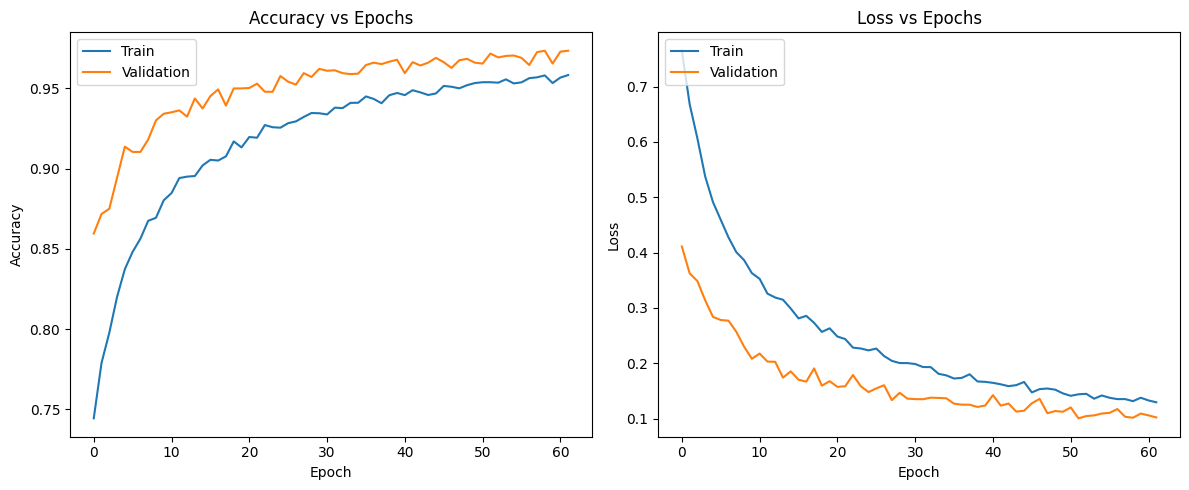

In [56]:
# show the results
num_epochs = len(history.history['accuracy'])
print(f'Number of Epochs: {num_epochs}\n')

final_train_accuracy = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]
print(f'Training Accuracy: {final_train_accuracy}')
print(f'Training Loss: {final_train_loss}\n')

# evaluating the test set on the model
test_loss, test_accuracy = new_model.evaluate(test_images_resized, test_labels)
print(f'Test Accuracy: {test_accuracy}')
print(f'Test Loss: {test_loss}')

# plot the results
plotAccuracyLossVsEpochs(history=history)

The needed number of epochs is **62 epochs**.

The training accuracy: **95.83%**

The training loss: **0.129**

The test accuracy: **97.17%**

The test loss: **0.1004**

| Metric                         | Task 1 (Without Data Augmentation) | Task 2 (With Data Augmentation) | Task 3 (LeNet with Augmentation) | Task 4 (Pretrained Transfer Learning) |
|--------------------------------|--------------------------------------|-----------------------------------|----------------------------------|---------------------------------------|
| Number of Epochs               | 61                                   | 98                                | 68                               | 62                                    |
| Training Accuracy              | 92.91%                               | 84.06%                            | 88.83%                           | 95.83%                                |
| Training Loss                  | 0.1886                               | 0.4905                            | 0.3272                           | 0.1294                                |
| Test Accuracy                  | 95.00%                               | 95.33%                            | 94.08%                           | 97.17%                                |
| Test Loss                      | 0.1880                               | 0.1477                            | 0.1880                           | 0.1004                                |
| Training Time (per epoch)      | 1s 3ms/step                          | 5s 25ms/step                      | 5s 25ms/step                     | 5s 25ms/step                                     |


## **Comparison**

### **Number of Epochs:**
Task 1 required 61 epochs, task 2 needed 98 epochs, task 3 utilized 68 epochs, and task 4 took 62 epochs to reach a satisfactory level of training. Task 1 had the lowest number of epochs, benefiting from the absence of data augmentation, suggesting faster convergence. Task 2 required the highest number of epochs due to the regularization effect of data augmentation. LeNet in task 3 needed slightly more epochs than task 1 but fewer than task 2, highlighting its improved learning capability. The pretrained model in task 4 demonstrated efficient training in a relatively low number of epochs which was close to the number of epochs of the model of task 1 (without data augmentation).

### **Training Accuracy and Loss:**
The pretrained model outperformed all of the previous models in all metrics due to transfer learning, which leveraged features learned from a larger dataset. Its capacity to extract meaningful representations, minimize training time, prevent overfitting, and increase convergence all contributed to better performance. Transfer learning enabled the model to swiftly adapt to the target task, demonstrating the effectiveness of utilizing prior knowledge to improve accuracy and speed up convergence.

### **Test Accuracy and Loss:**
The pretrained model indicates the highest test accuracy and lowest test loss, indicating effective transfer learning as mentioned in the previous point.

### **Training Time per Epoch:**
Task 1 had the shortest training time per epoch, emphasizing efficiency without data augmentation. All other models almost took the same time.

### **The Plots:**
All tasks showed increasing accuracies and decreasing losses over time in their plots. The learning curve was less smoother, maybe when we reduce the learning rate it will become smoother. Anyways, the pretrained model, demonstrated effective transfer learning with the learning curve, validating its ability to leverage prior knowledge for improved performance.


# **Conclusion**

In conclusion, our exploration of deep learning models for Arabic handwritten character recognition (AHCR) yielded valuable insights and showed the features and advantages for different models. The basic CNN showed a good accuracy, efficiency, less time and less computational cost. The data augmentation added to the model, exhibited improved generalization at the cost of an extended training period. Using well-known architecture such as the LeNet architecture with similar data augmentation outperformed the augmented basic CNN, highlighting the effectiveness of LeNet for AHCR, but using other architecture may show different results based on the architecture itself and its specific. Employing a pretrained model through transfer learning, surpassed all others in accuracy and loss metrics. Each task contributed valuable insights, emphasizing the importance of selecting models based on specific goals, balancing trade-offs between training efficiency, generalization, and computational demands.

| Model                          | Key Features and Performance                                           |
|--------------------------------|------------------------------------------------------------------------|
| Task 1 (Basic CNN)              | Simple convolutional neural network architecture with less computational cost.|
| Task 2 (CNN with Data Aug.)     | Utilizes data augmentation for regularization and improved generalization.|
| Task 3 (LeNet with Aug.)        | LeNet architecture with data augmentation, striking a balance in complexity.|
| Task 4 (Transfer Learning)      | Incorporates transfer learning using a pretrained model for enhanced performance.|
